# Model Performance

In [1]:
# load libraries
from dotenv import load_dotenv 
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import yfinance as yf
from numerapi import NumerAPI
import os

# set env vars
load_dotenv()
PUBLIC_ID = os.getenv('PUBLIC_ID')
SECRET_KEY = os.getenv('SECRET_KEY')

# set plot params
plt.rcParams["figure.figsize"] = (14, 5)
plt.style.use("bmh")

In [2]:
# instantiate
TODAY = dt.datetime.now()
AFTER_DATE = "2022-04-01"
AFTER_ERA = 310

nmr = yf.download('NMR-USD', start=AFTER_DATE, end=TODAY, progress=False)
napi = NumerAPI(public_id=PUBLIC_ID, secret_key=SECRET_KEY)

In [3]:
# get model ranking
def get_model_rankings(model_list):
    df_list = []
    for m in model_list:
        df = pd.DataFrame.from_dict(napi.daily_model_performances(m))
        df['modelName'] = m
        df_list.append( df)
    df_all = pd.concat(df_list)
    return df_all

# get model round performance
def get_model_performance(model_list):
    df_list = []
    for m in model_list:
        df = pd.DataFrame.from_dict(napi.daily_submissions_performances(m))
        df['modelName'] = m
        df_list.append( df)
    df_all = pd.concat(df_list)
    return df_all

# get model round performance aggregated
def get_model_performance_aggregated(data, score, by):
    df = pd.pivot_table(
        data=data.groupby(["modelName", by])[score].mean().reset_index(),
        values=score,
        index=[by],
        columns=["modelName"]
    )
    return df

# get model payout & staking history
def get_model_value(model_list, mode):
    df_list = []
    for m in model_list:
        df = pd.DataFrame.from_dict(napi.round_model_performances(m))
        df["modelName"] = m
        df_list.append(df)
    df_all = pd.concat(df_list)
    df_all = df_all.loc[df_all["roundResolved"]==True]
    
    if mode == "payout":
        mode_value = "payout"
    elif mode == "staking":
        mode_value = "selectedStakeValue"
    else:
        print("Select either 'payout' or 'staking' as mode.")

    output = pd.pivot_table(
        df_all, 
        values=mode_value, 
        index=['roundResolveTime'], 
        columns=['modelName']).fillna(0)
    output["totalValue"] = output.sum(axis=1)

    return output

In [4]:
# nmr price
nmr_price = nmr[['Open', 'High', 'Low', 'Close']].mean(axis=1)[-1]
nmr_price

11.028042078018188

In [5]:
# get model names
model_list = napi.get_models().keys()
model_list

dict_keys(['dh_foxhound', 'dh_deadcell', 'dh_cobra', 'dh_beautybeast', 'dh_skulls', 'dh_dojo', 'dh_gaia', 'dh_terra', 'dh_spira'])

---
# Model Ranks

In [6]:
# get model rankings
rank = get_model_rankings(model_list=model_list)
rank.head()

,corrRank,corrRep,date,fncRank,fncRep,fncV3Rank,fncV3Rep,mmcRank,mmcRep,tcRank,tcRep,modelName
0,5447,0.004845,2022-11-12 00:00:00+00:00,3975,0.000774,4356.0,-0.000784,6055,-0.003655,2684.0,0.013222,dh_foxhound
1,5634,0.003305,2022-11-11 00:00:00+00:00,4479,-0.000973,4789.0,-0.002701,6078,-0.003976,2887.0,0.012644,dh_foxhound
2,5619,0.003951,2022-11-10 00:00:00+00:00,4747,-0.001167,4930.0,-0.002691,6105,-0.003898,1718.0,0.021181,dh_foxhound
3,5522,0.004532,2022-11-09 00:00:00+00:00,4476,-0.001008,4693.0,-0.002226,6006,-0.003679,1430.0,0.024205,dh_foxhound
4,5358,0.006160,2022-11-08 00:00:00+00:00,4145,0.000429,4582.0,-0.001352,5942,-0.003548,1480.0,0.024805,dh_foxhound


In [7]:
# check model name list
rank["modelName"].unique()

array(['dh_foxhound', 'dh_deadcell', 'dh_cobra', 'dh_beautybeast',
       'dh_skulls', 'dh_dojo', 'dh_gaia', 'dh_terra', 'dh_spira'],
      dtype=object)

In [8]:
# cols
tc_rank_cols = [col for col in rank.columns if col.endswith("Rank") and col.startswith("tc")]
tc_rep_cols = [col for col in rank.columns if col.endswith("Rep") and col.startswith("tc")]
nontc_rank_cols = [col for col in rank.columns if col.endswith("Rank") and not col.startswith("tc")]
nontc_rep_cols = [col for col in rank.columns if col.endswith("Rep") and not col.startswith("tc")]

tc_rank_cols, tc_rep_cols, nontc_rank_cols, nontc_rep_cols

(['tcRank'],
 ['tcRep'],
 ['corrRank', 'fncRank', 'fncV3Rank', 'mmcRank'],
 ['corrRep', 'fncRep', 'fncV3Rep', 'mmcRep'])

---
# Correlation Ranking & Reputation

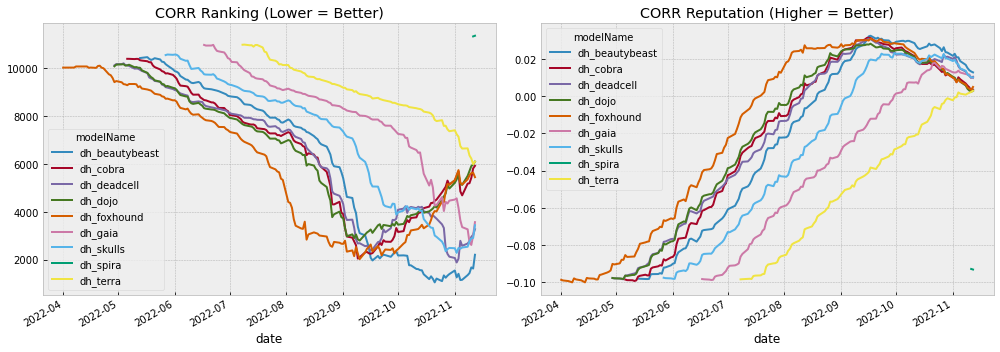

In [9]:
# plot  corr rank and rep
corrdf = rank.loc[rank["date"]>=AFTER_DATE]

fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=False)

pd.pivot_table(
    data=corrdf[["modelName", "date", "corrRank"]],
    values="corrRank",
    index="date",
    columns="modelName"
).plot(ax=axes[0])
axes[0].set_title("CORR Ranking (Lower = Better)")

pd.pivot_table(
    data=corrdf[["modelName", "date", "corrRep"]],
    values="corrRep",
    index="date",
    columns="modelName"
).plot(ax=axes[1])
axes[1].set_title("CORR Reputation (Higher = Better)")

plt.tight_layout()
plt.savefig('plots/CorrRankPlots.png', facecolor='w')
plt.show()

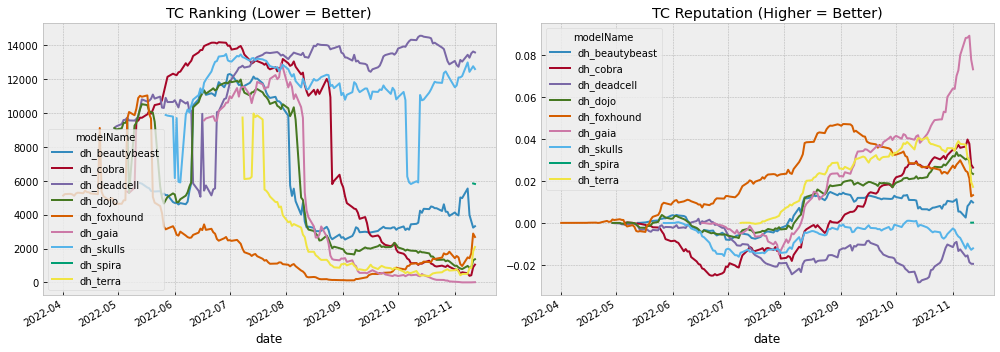

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=False)
pd.pivot_table(
    data=corrdf[["modelName", "date", "tcRank"]],
    values="tcRank",
    index="date",
    columns="modelName"
).plot(ax=axes[0])
axes[0].set_title("TC Ranking (Lower = Better)")

pd.pivot_table(
    data=corrdf[["modelName", "date", "tcRep"]],
    values="tcRep",
    index="date",
    columns="modelName"
).plot(ax=axes[1])
axes[1].set_title("TC Reputation (Higher = Better)")

plt.tight_layout()
plt.savefig('plots/TCRankPlots.png', facecolor='w')
plt.show()

---
# Model Performance by Round

In [11]:
# get round performance
perf = get_model_performance(model_list=model_list)
perf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8634 entries, 0 to 5
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype                  
---  ------                    --------------  -----                  
 0   corrPercentile            7626 non-null   float64                
 1   correlation               8634 non-null   float64                
 2   correlationWithMetamodel  7626 non-null   float64                
 3   date                      8634 non-null   datetime64[ns, tzutc()]
 4   fnc                       4904 non-null   float64                
 5   fncPercentile             4904 non-null   float64                
 6   mmc                       7626 non-null   float64                
 7   mmcPercentile             7626 non-null   float64                
 8   roundNumber               8634 non-null   int64                  
 9   tc                        6661 non-null   float64                
 10  tcPercentile              6661 non-null

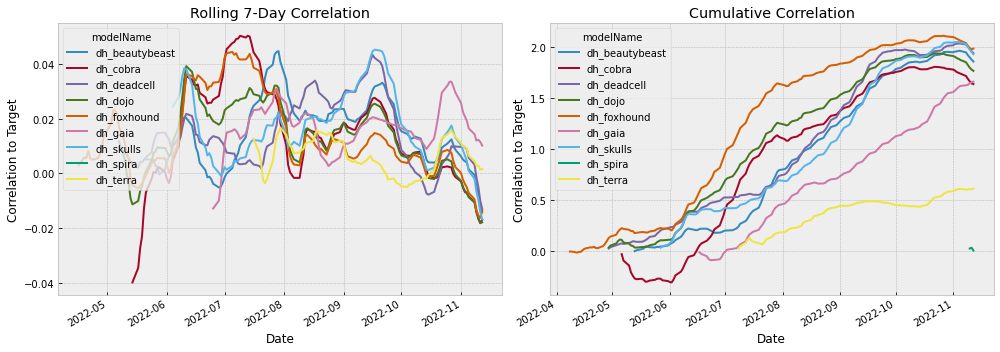

In [12]:
# get mean corr by round
avg_corr_by_era = get_model_performance_aggregated(data=perf, score="correlation", by="roundNumber")
avg_corr_by_date = get_model_performance_aggregated(data=perf, score="correlation", by="date")

# plot
fig, axes = plt.subplots(nrows=1, ncols=2)
avg_corr_by_date.loc[AFTER_DATE:].rolling(7).mean().plot(ax=axes[0])
avg_corr_by_date.loc[AFTER_DATE:].cumsum().plot(ax=axes[1])
axes[0].set_title("Rolling 7-Day Correlation")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Correlation to Target")
axes[1].set_title("Cumulative Correlation")
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Correlation to Target")
plt.tight_layout()
plt.savefig('plots/ModelCorrPlots.png', facecolor='w')
plt.show()

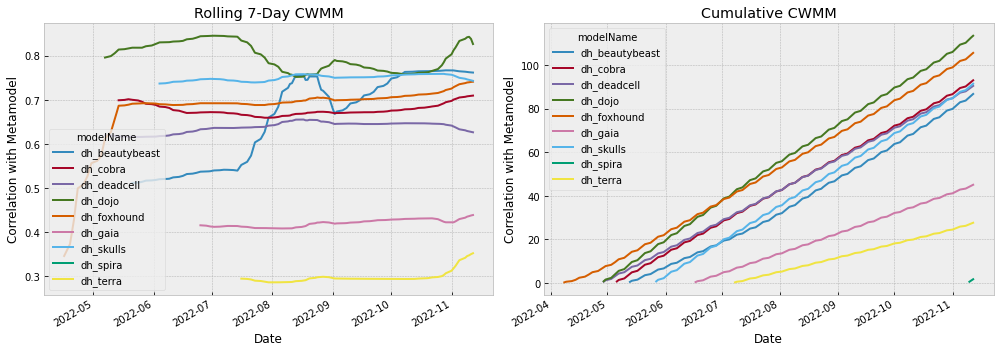

In [13]:
# get mean cwmm by round
avg_cwmm_by_era = get_model_performance_aggregated(data=perf,score="correlationWithMetamodel", by="roundNumber")
avg_cwmm_by_date = get_model_performance_aggregated(data=perf,score="correlationWithMetamodel", by="date")

# plot
fig, axes = plt.subplots(nrows=1, ncols=2)
avg_cwmm_by_date.loc[AFTER_DATE:].rolling(7).mean().plot(ax=axes[0])
avg_cwmm_by_date.loc[AFTER_DATE:].cumsum().plot(ax=axes[1])
axes[0].set_title("Rolling 7-Day CWMM")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Correlation with Metamodel")
axes[1].set_title("Cumulative CWMM")
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Correlation with Metamodel")
plt.tight_layout()
plt.savefig('plots/ModelCWMMPlots.png', facecolor='w')
plt.show()

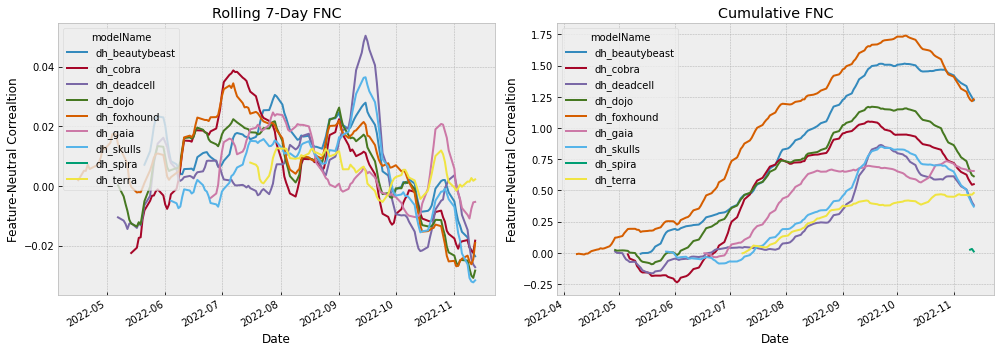

In [14]:
# get mean fnc by round
avg_fnc_by_era = get_model_performance_aggregated(data=perf,score="fnc", by="roundNumber")
avg_fnc_by_date = get_model_performance_aggregated(data=perf,score="fnc", by="date")

# plot
fig, axes = plt.subplots(nrows=1, ncols=2)
avg_fnc_by_date.loc[AFTER_DATE:].rolling(7).mean().plot(ax=axes[0])
avg_fnc_by_date.loc[AFTER_DATE:].cumsum().plot(ax=axes[1])
axes[0].set_title("Rolling 7-Day FNC")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Feature-Neutral Correaltion")
axes[1].set_title("Cumulative FNC")
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Feature-Neutral Correaltion")
plt.tight_layout()
plt.savefig('plots/ModelFNCPlots.png', facecolor='w')
plt.show()

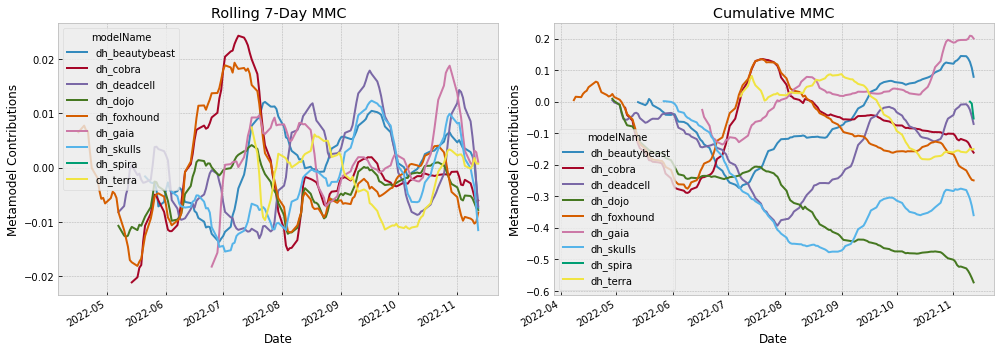

In [15]:
# get mean mmc by round
avg_mmc_by_era = get_model_performance_aggregated(data=perf,score="mmc", by="roundNumber")
avg_mmc_by_date = get_model_performance_aggregated(data=perf,score="mmc", by="date")

# plot
fig, axes = plt.subplots(nrows=1, ncols=2)
avg_mmc_by_date.loc[AFTER_DATE:].rolling(7).mean().plot(ax=axes[0])
avg_mmc_by_date.loc[AFTER_DATE:].cumsum().plot(ax=axes[1])
axes[0].set_title("Rolling 7-Day MMC")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Metamodel Contributions")
axes[1].set_title("Cumulative MMC")
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Metamodel Contributions")
plt.tight_layout()
plt.savefig('plots/ModelMMCPlots.png', facecolor='w')
plt.show()

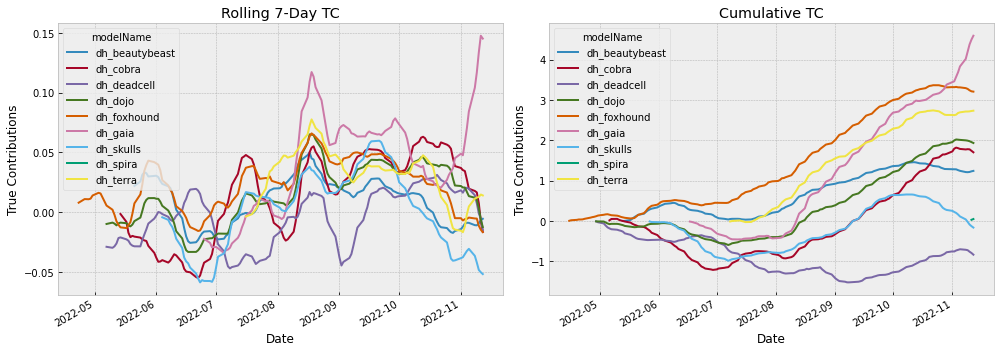

In [16]:
# get mean mmc by round
avg_tc_by_era = get_model_performance_aggregated(data=perf,score="tc", by="roundNumber")
avg_tc_by_date = get_model_performance_aggregated(data=perf,score="tc", by="date")

# plot
fig, axes = plt.subplots(nrows=1, ncols=2)
avg_tc_by_date.loc[AFTER_DATE:].rolling(7).mean().plot(ax=axes[0])
avg_tc_by_date.loc[AFTER_DATE:].cumsum().plot(ax=axes[1])
axes[0].set_title("Rolling 7-Day TC")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("True Contributions")
axes[1].set_title("Cumulative TC")
axes[1].set_xlabel("Date")
axes[1].set_ylabel("True Contributions")
plt.tight_layout()
plt.savefig('plots/ModelTCPlots.png', facecolor='w')
plt.show()

---
# Model Payouts & Staking

In [17]:
# get payout
payout = get_model_value(model_list, "payout")

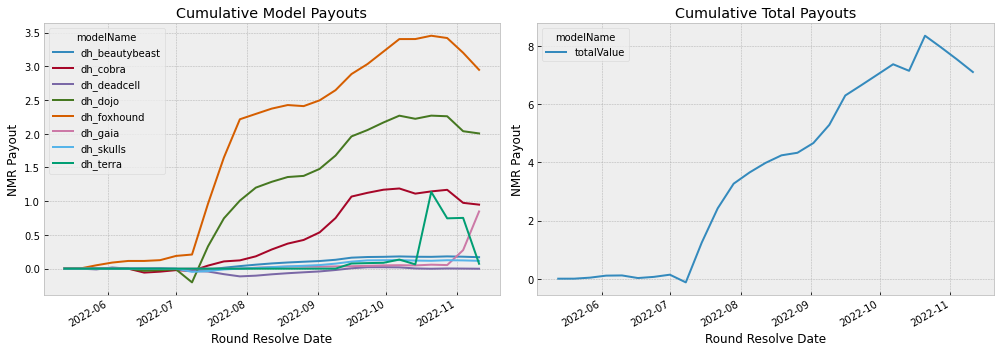

In [18]:
# plot payouts
fig, axes = plt.subplots(nrows=1, ncols=2)
payout.loc[AFTER_DATE:][[col for col in payout.columns if col.startswith("dh_")]].cumsum().plot(ax=axes[0])
payout.loc[AFTER_DATE:][["totalValue"]].cumsum().plot(ax=axes[1])
axes[0].set_title("Cumulative Model Payouts")
axes[0].set_xlabel("Round Resolve Date")
axes[0].set_ylabel("NMR Payout")
axes[1].set_title("Cumulative Total Payouts")
axes[1].set_xlabel("Round Resolve Date")
axes[1].set_ylabel("NMR Payout")
plt.tight_layout()
plt.savefig('plots/PayoutPlots.png', facecolor='w')
plt.show()

In [19]:
# get payout
staking = get_model_value(model_list, "staking")

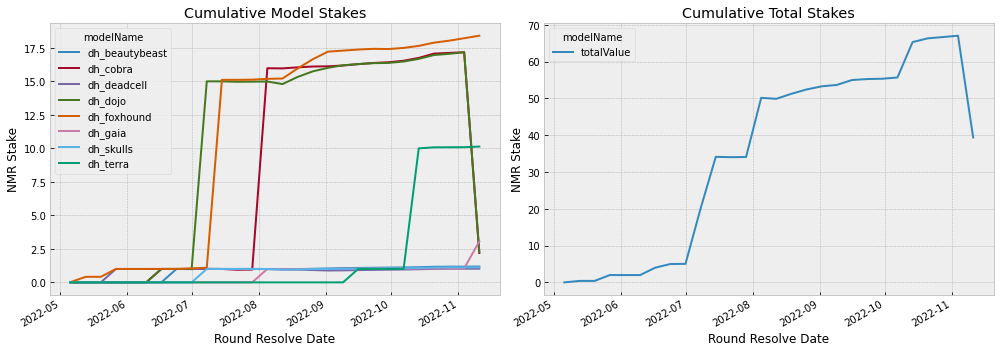

In [20]:
# plot payouts
fig, axes = plt.subplots(nrows=1, ncols=2)
staking.loc[AFTER_DATE:][[col for col in staking.columns if col.startswith("dh_")]].plot(ax=axes[0])
staking.loc[AFTER_DATE:][["totalValue"]].plot(ax=axes[1])
axes[0].set_title("Cumulative Model Stakes")
axes[0].set_xlabel("Round Resolve Date")
axes[0].set_ylabel("NMR Stake")
axes[1].set_title("Cumulative Total Stakes")
axes[1].set_xlabel("Round Resolve Date")
axes[1].set_ylabel("NMR Stake")
plt.tight_layout()
plt.savefig('plots/ModelStakingPlots.png', facecolor='w')
plt.show()

---
# Total Return

In [21]:
# get return
total_return = pd.concat([payout.sum(), staking.tail(1).T], axis=1)
total_return.columns = ["payout", "staking"]
total_return["return"] = total_return["payout"] / total_return["staking"]

total_return

,payout,staking,return
modelName,,,
dh_beautybeast,0.169748,1.181077,0.143723
dh_cobra,0.948959,2.188581,0.433596
dh_deadcell,-0.001440,1.018925,-0.001413
dh_dojo,2.004909,2.268305,0.883880
dh_foxhound,2.952533,18.404129,0.160428
dh_gaia,0.847828,3.050950,0.277890
dh_skulls,0.115756,1.126608,0.102748
dh_terra,0.072574,10.134654,0.007161
totalValue,7.110868,39.373230,0.180602


In [22]:
# daily staking 
round_return = pd.concat([payout["totalValue"], staking["totalValue"]], axis=1)[AFTER_DATE:].fillna(0)
round_return.columns = ["payout", "staking"]
round_return["return"] = round_return["payout"] / round_return["staking"]

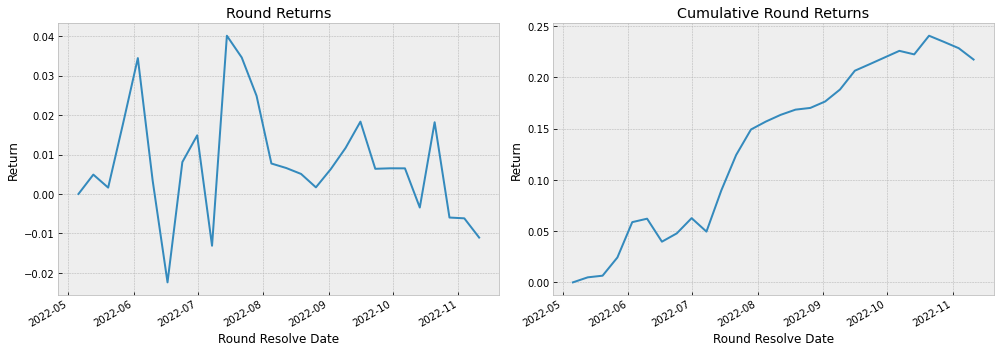

In [23]:
# plot round return
fig, axes = plt.subplots(nrows=1, ncols=2)

# plt.figure()
round_return["return"].plot(ax=axes[0])
round_return["return"].cumsum().plot(ax=axes[1])
axes[0].set_title("Round Returns")
axes[0].set_xlabel("Round Resolve Date")
axes[0].set_ylabel("Return")
axes[1].set_title("Cumulative Round Returns")
axes[1].set_xlabel("Round Resolve Date")
axes[1].set_ylabel("Return")
plt.tight_layout()
plt.savefig('plots/TotalReturnPlots.png', facecolor='w')
plt.show()

---
# Sharpe Performance

In [24]:
# sharpe calc
def get_sharpe(df, metric):
    def sharpe(x):
        return x.mean() / x.std()
    df_clean = df.query(f"roundNumber >= {AFTER_ERA}").copy()
    sharpe_df = pd.concat([
        df_clean.groupby(["modelName"])[metric].size(),
        df_clean.groupby(["modelName"])[metric].apply(lambda x: sharpe(x))], 
        axis=1)
    sharpe_df.columns = ["n", "sharpe"]
    sharpe_df = sharpe_df.loc[sharpe_df["n"]>=10].sort_values("sharpe")
    return sharpe_df

In [25]:
# rank by sharpe
corr_sharpe_df = get_sharpe(df=perf, metric='correlation')
tc_sharpe_df = get_sharpe(df=perf, metric='tc')

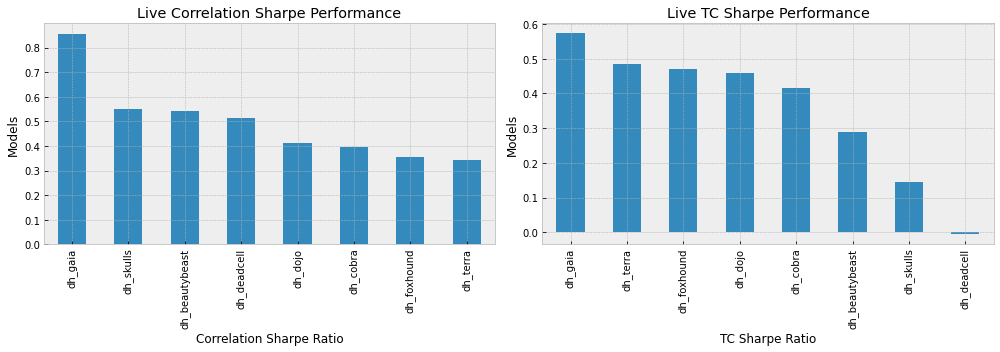

In [26]:
# plot both
fig, axes = plt.subplots(nrows=1, ncols=2)
corr_sharpe_df["sharpe"].sort_values(ascending=False).plot.bar(ax=axes[0])
tc_sharpe_df["sharpe"].sort_values(ascending=False).plot.bar(ax=axes[1])
axes[0].set_title("Live Correlation Sharpe Performance")
axes[0].set_xlabel("Correlation Sharpe Ratio")
axes[0].set_ylabel("Models")
axes[1].set_title("Live TC Sharpe Performance")
axes[1].set_xlabel("TC Sharpe Ratio")
axes[1].set_ylabel("Models")
plt.tight_layout()
plt.savefig('plots/SharpeRatioPlots.png', facecolor='w')
plt.show();

In [27]:
# sharpe calc (ts)
def get_sharpe_ts(df, metric):
    def sharpe(x):
        return x.mean() / x.std()
    df_clean = df.query(f"roundNumber >= {AFTER_ERA}").copy()
    sharpe_df = pd.concat([
        df_clean.groupby(["roundNumber", "modelName"])[metric].size(),
        df_clean.groupby(["roundNumber", "modelName"])[metric].apply(lambda x: sharpe(x))], 
        axis=1)
    sharpe_df.columns = ["n", "sharpe"]
    sharpe_df = (
        sharpe_df
        .loc[sharpe_df["n"]>=10]
        .reset_index()
        .sort_values(["modelName", "roundNumber"])
        .drop("n", axis=1)
        .pivot(index='roundNumber', columns='modelName', values='sharpe'))
    return sharpe_df

In [28]:
# rank by sharpe ts
corr_sharpets_df = get_sharpe_ts(df=perf, metric='correlation')
tc_sharpets_df = get_sharpe_ts(df=perf, metric='tc')

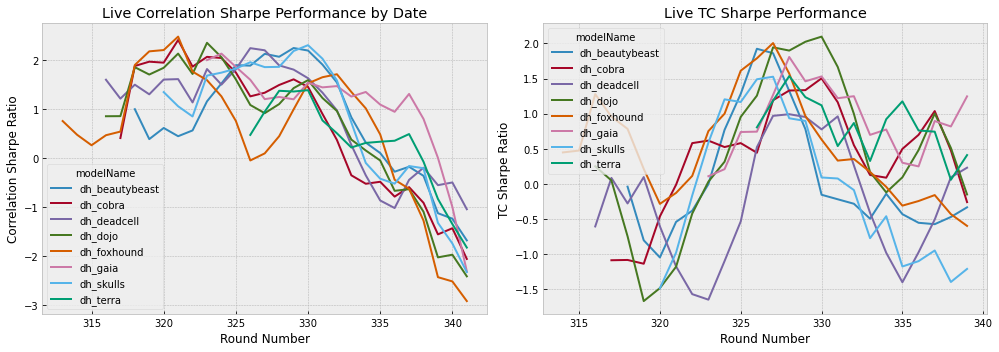

In [29]:
# plot both
fig, axes = plt.subplots(nrows=1, ncols=2)
corr_sharpets_df.rolling(4).mean().plot(ax=axes[0])
tc_sharpets_df.rolling(4).mean().plot(ax=axes[1])
axes[0].set_title("Live Correlation Sharpe Performance by Date")
axes[0].set_xlabel("Round Number")
axes[0].set_ylabel("Correlation Sharpe Ratio")
axes[1].set_title("Live TC Sharpe Performance")
axes[1].set_xlabel("Round Number")
axes[1].set_ylabel("TC Sharpe Ratio")
plt.tight_layout()
plt.savefig('plots/SharpeRatioTSPlots.png', facecolor='w')
plt.show();